In [121]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch

import copy
import random

In [122]:
def create_dataset(df, shuffle=True):

  sequences = df.astype(np.float32).to_numpy().tolist()

  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

  if shuffle: 
    random.Random(6).shuffle(dataset)

  n_seq, seq_len, n_features = torch.stack(dataset).shape

  return dataset, seq_len, n_features

In [123]:
df = pd.read_csv("data/mit_bih.csv", index_col=0)
df.head()

,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,...,t_170,t_171,t_172,t_173,t_174,t_175,t_176,t_177,t_178,t_179
0,0.580723,0.579518,0.581928,0.580723,0.584337,0.581928,0.581928,0.580723,0.580723,0.584337,...,0.553012,0.555422,0.554217,0.551807,0.553012,0.549398,0.550602,0.550602,0.553012,0.550602
1,0.574699,0.571084,0.571084,0.568675,0.569880,0.572289,0.574699,0.572289,0.572289,0.572289,...,0.557831,0.554217,0.556627,0.556627,0.555422,0.554217,0.553012,0.553012,0.551807,0.554217
2,0.563855,0.561446,0.568675,0.567470,0.568675,0.567470,0.567470,0.565060,0.567470,0.571084,...,0.566265,0.565060,0.563855,0.561446,0.560241,0.560241,0.563855,0.566265,0.561446,0.562651
3,0.571084,0.571084,0.569880,0.568675,0.571084,0.574699,0.574699,0.573494,0.573494,0.572289,...,0.556627,0.551807,0.551807,0.551807,0.553012,0.551807,0.545783,0.546988,0.545783,0.549398
4,0.572289,0.572289,0.572289,0.575904,0.575904,0.575904,0.571084,0.569880,0.572289,0.574699,...,0.557831,0.559036,0.559036,0.556627,0.555422,0.551807,0.551807,0.555422,0.555422,0.553012


In [124]:
df.iloc[0]

t_0      0.580723
t_1      0.579518
t_2      0.581928
t_3      0.580723
t_4      0.584337
           ...   
t_175    0.549398
t_176    0.550602
t_177    0.550602
t_178    0.553012
t_179    0.550602
Name: 0, Length: 180, dtype: float64

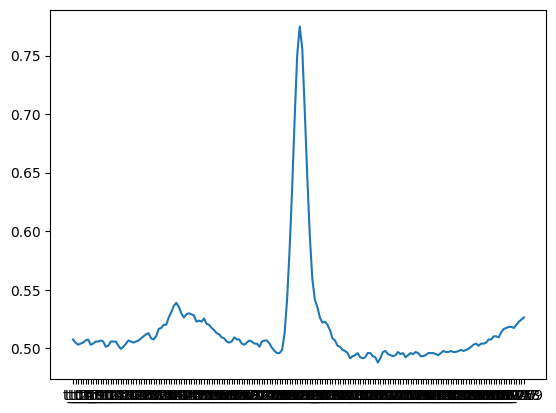

In [125]:
plt.plot(df.iloc[2341,:])

In [126]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [127]:
def train_model(model, train_dataset, val_dataset, n_epochs, lr):
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  criterion = torch.nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  
  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for seq_true in train_dataset:

      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()


      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:

        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    # if val_loss < best_loss:
    #   best_loss = val_loss
    #   best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  return model.eval(), history

In [128]:
dataset,seq_len, n_feat = create_dataset(df)
dataset = dataset[0:1]

In [129]:
dataset[0].shape

torch.Size([180, 1])

In [130]:
from lstmae import RecurrentAutoencoder

model = RecurrentAutoencoder(seq_len, n_feat, device, 32)
model = model.to(device)
model

RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 64, batch_first=True)
    (rnn2): LSTM(64, 32, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(32, 32, batch_first=True)
    (rnn2): LSTM(32, 64, batch_first=True)
    (output_layer): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [131]:
train_ratio = 0.7
test_ratio = 0.1
train_index = int(len(dataset)*train_ratio)
test_index = int(len(dataset)*test_ratio) + train_index
train = dataset[0:train_index]
test = dataset[train_index:test_index]
val = dataset[test_index::]
assert len(train)+len(test)+len(val) == len(dataset)

In [293]:
model, history = train_model(
  model, 
  train_dataset=val, 
  val_dataset=val, 
  n_epochs=10000,
  lr=5e-5
)

Epoch 1: train loss 4.967577934265137 val loss 5.008703231811523
Epoch 2: train loss 5.008703231811523 val loss 4.9721832275390625
Epoch 3: train loss 4.9721832275390625 val loss 4.973094940185547
Epoch 4: train loss 4.973094940185547 val loss 4.987540245056152
Epoch 5: train loss 4.987540245056152 val loss 4.988859176635742
Epoch 6: train loss 4.988859176635742 val loss 4.9800872802734375
Epoch 7: train loss 4.9800872802734375 val loss 4.969832897186279
Epoch 8: train loss 4.969832897186279 val loss 4.969657897949219
Epoch 9: train loss 4.969657897949219 val loss 4.975615501403809
Epoch 10: train loss 4.975615501403809 val loss 4.980669975280762
Epoch 11: train loss 4.980669975280762 val loss 4.97510290145874
Epoch 12: train loss 4.97510290145874 val loss 4.97036600112915
Epoch 13: train loss 4.97036600112915 val loss 4.967205047607422
Epoch 14: train loss 4.967205047607422 val loss 4.970329284667969
Epoch 15: train loss 4.970329284667969 val loss 4.972956657409668
Epoch 16: train los

In [15]:
torch.save(model, "models/lstmae_5000")

In [69]:
torch.load("models/lstmae_5000", map_location=torch.device('cpu'))

RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 256, batch_first=True)
    (rnn2): LSTM(256, 128, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(128, 128, batch_first=True)
    (rnn2): LSTM(128, 256, batch_first=True)
    (output_layer): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [294]:
model = model.to(device="cpu")

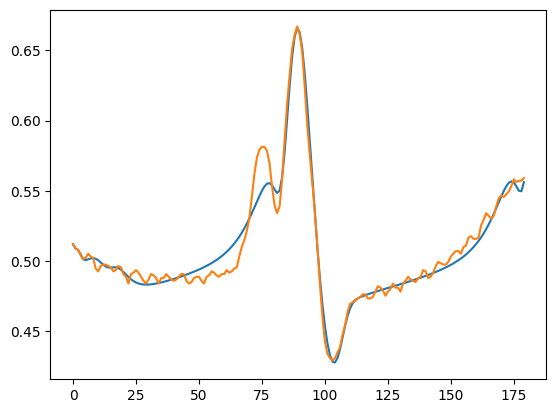

In [295]:
plt.plot(model(dataset[0]).cpu().detach().numpy().squeeze())
plt.plot(dataset[0].cpu().detach().numpy().squeeze())